### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [306]:
# This is the file and analysis data range used for the main hard court analysis
#df = pd.read_csv('../data/df_player_all_2012to2019.csv')
#df.head()

,p_pts_won%,p_sv_pts_won%,p_ret_pts_won%,p_ace%,p_aced%,p_bp_save%,p_bp_convert%,t_id,t_date,tour_wk,...,p_tot_pts_last_diff,p_tot_pts_l6_diff,p_tot_pts_l6_decay_diff,p_matches_diff,p_matches_surf_diff,p_stam_adj_fatigue_diff,p_stam_adj_fatigue_decay_diff,p_H2H_diff,p_H2H_pts_won%_diff,m_outcome
0,47.84,56.28,38.41,1.09,3.66,55.00,43.75,2019-560,20190826,2019_24,...,-0.0,-0.0,-0.0,-224.0,-99.0,177.984496,133.488372,-0.0,NaN,0
1,41.29,49.40,31.94,4.82,15.28,33.33,40.00,2019-M014,20191014,2019_29,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,NaN,0
2,37.23,51.85,17.50,3.70,5.00,33.33,0.00,2019-M004,20190225,2019_07,...,-0.0,-0.0,-0.0,-25.0,-24.0,133.805310,100.353982,-0.0,NaN,0
3,59.14,69.23,46.34,3.85,4.88,100.00,37.50,2019-7696,20191105,2019_33,...,9.0,49.0,46.9,-79.0,-77.0,109.423559,90.917141,0.0,NaN,1
4,53.66,70.77,34.48,7.69,3.45,88.89,37.50,2019-7696,20191105,2019_33,...,53.0,44.0,42.5,-17.0,-20.0,55.064126,48.178912,0.0,NaN,1


In [2]:
# This is the file and analysis data range used ONLY for presentation model subraction of time-decay weighting
df = pd.read_csv('../data/df_player_all_2012to2019_no_decay_weighting.csv')
df.head()

,p_pts_won%,p_sv_pts_won%,p_ret_pts_won%,p_ace%,p_aced%,p_bp_save%,p_bp_convert%,t_id,t_date,tour_wk,...,p_tot_pts_last_diff,p_tot_pts_l6_diff,p_tot_pts_l6_decay_diff,p_matches_diff,p_matches_surf_diff,p_stam_adj_fatigue_diff,p_stam_adj_fatigue_decay_diff,p_H2H_diff,p_H2H_pts_won%_diff,m_outcome
0,47.84,56.28,38.41,1.09,3.66,55.00,43.75,2019-560,20190826,2019_24,...,-0.0,-0.0,-0.0,-224.0,-99.0,177.984496,177.984496,-0.0,NaN,0
1,41.29,49.40,31.94,4.82,15.28,33.33,40.00,2019-M014,20191014,2019_29,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,NaN,0
2,37.23,51.85,17.50,3.70,5.00,33.33,0.00,2019-M004,20190225,2019_07,...,-0.0,-0.0,-0.0,-25.0,-24.0,133.805310,133.805310,-0.0,NaN,0
3,59.14,69.23,46.34,3.85,4.88,100.00,37.50,2019-7696,20191105,2019_33,...,9.0,49.0,49.0,-79.0,-77.0,109.423559,109.423559,0.0,NaN,1
4,53.66,70.77,34.48,7.69,3.45,88.89,37.50,2019-7696,20191105,2019_33,...,53.0,44.0,44.0,-17.0,-20.0,55.064126,55.064126,0.0,NaN,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36336 entries, 0 to 36335
Columns: 160 entries, p_pts_won% to m_outcome
dtypes: float64(138), int64(16), object(6)
memory usage: 44.4+ MB


In [4]:
df["p_matches_surf"]

0         1.0
1         1.0
2         1.0
3        12.0
4        11.0
         ... 
36331     4.0
36332     3.0
36333     2.0
36334     1.0
36335     1.0
Name: p_matches_surf, Length: 36336, dtype: float64

In [5]:
# This is the data range used for the main analysis for hard courts- 2015-2019 in model; 2012-2014 used for additional stats accrual "runway"
df_filter = df[~df['tour_wk'].str.contains("2012")] 
df_filter = df_filter[~df_filter['tour_wk'].str.contains("2013")]
df_filter = df_filter[~df_filter['tour_wk'].str.contains("2014")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2015")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2016")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2017")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2018")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2019")]

In [6]:
# Filter down to only matches played on hard courts
df_filter2 = df_filter.loc[(df_filter["t_surf"] == 2)]
#df_filter2 = df_filter.loc[(df_filter["t_surf"] == 2) & (df_filter["p_matches_surf"] > 50)]

In [7]:
# Now also will remove BOTH players from individual matches remaining in the surface-specific sample already filtered by year range
# where one or both players has played N or fewer matches prior to the one to be predicted on. 
df_low = df_filter2.loc[df_filter2['p_matches_surf'] <= 20, 'm_num']
df_filter3 = df_filter2[~df_filter2['m_num'].isin(df_low)]

In [254]:
#All Predictive Features
#df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_pts_won%_l10", "p_SOS_adj_pts_won%_l60_decay", "p_SOS_adj_pts_won%_l60_decay_IO", "p_SOS_adj_pts_won%_l60_decay_IO_weighted", "p_SOS_adj_pts_won%_l10", "p_sv_pts_won%_l60_decay", "p_sv_pts_won%_l10", "p_SOS_adj_sv_pts_won%_l60_decay", "p_SOS_adj_sv_pts_won%_l10", "p_ret_pts_won%_l60_decay", "p_ret_pts_won%_l10", "p_SOS_adj_ret_pts_won%_l60_decay", "p_SOS_adj_ret_pts_won%_l10", "p_ace%_l60_decay", "p_ace%_l10", "p_SOS_adj_ace%_l60_decay", "p_SOS_adj_ace%_l10", "p_aced%_l60_decay", "p_aced%_l10", "p_SOS_adj_aced%_l60_decay", "p_SOS_adj_aced%_l10", "p_bp_save%_l60", "p_bp_save%_l10", "p_SOS_adj_bp_save%_l60", "p_SOS_adj_bp_save%_l10", "p_bp_convert%_l60", "p_bp_convert%_l10", "p_SOS_adj_bp_convert%_l60", "p_SOS_adj_bp_convert%_l10", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", 'p_sv_pts_won%_std_l60_decay_diff','p_ret_pts_won%_std_l60_decay_diff', "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_matches_surf_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"]] #all features

In [312]:
#No Strength of Schedule Adjustment to Performance Features
#df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_pts_won%_l10", "p_sv_pts_won%_l60_decay", "p_sv_pts_won%_l10", "p_ret_pts_won%_l60_decay", "p_ret_pts_won%_l10", "p_ace%_l60_decay", "p_ace%_l10", "p_aced%_l60_decay", "p_aced%_l10", "p_bp_save%_l60", "p_bp_save%_l10", "p_bp_convert%_l60", "p_bp_convert%_l10", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", 'p_sv_pts_won%_std_l60_decay_diff','p_ret_pts_won%_std_l60_decay_diff', "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_matches_surf_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"]] 

In [32]:
# No Rankings Information
#df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_pts_won%_l10", "p_SOS_adj_pts_won%_l60_decay", "p_SOS_adj_pts_won%_l60_decay_IO", "p_SOS_adj_pts_won%_l60_decay_IO_weighted", "p_SOS_adj_pts_won%_l10", "p_sv_pts_won%_l60_decay", "p_sv_pts_won%_l10", "p_SOS_adj_sv_pts_won%_l60_decay", "p_SOS_adj_sv_pts_won%_l10", "p_ret_pts_won%_l60_decay", "p_ret_pts_won%_l10", "p_SOS_adj_ret_pts_won%_l60_decay", "p_SOS_adj_ret_pts_won%_l10", "p_ace%_l60_decay", "p_ace%_l10", "p_SOS_adj_ace%_l60_decay", "p_SOS_adj_ace%_l10", "p_aced%_l60_decay", "p_aced%_l10", "p_SOS_adj_aced%_l60_decay", "p_SOS_adj_aced%_l10", "p_bp_save%_l60", "p_bp_save%_l10", "p_SOS_adj_bp_save%_l60", "p_SOS_adj_bp_save%_l10", "p_bp_convert%_l60", "p_bp_convert%_l10", "p_SOS_adj_bp_convert%_l60", "p_SOS_adj_bp_convert%_l10", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "high_t_ace_p_ace", "high_t_ace_p_aced", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", 'p_sv_pts_won%_std_l60_decay_diff','p_ret_pts_won%_std_l60_decay_diff', "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_matches_surf_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"]] #all features

In [56]:
# No Player Head-to-Head Features
#df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_pts_won%_l10", "p_SOS_adj_pts_won%_l60_decay", "p_SOS_adj_pts_won%_l60_decay_IO", "p_SOS_adj_pts_won%_l60_decay_IO_weighted", "p_SOS_adj_pts_won%_l10", "p_sv_pts_won%_l60_decay", "p_sv_pts_won%_l10", "p_SOS_adj_sv_pts_won%_l60_decay", "p_SOS_adj_sv_pts_won%_l10", "p_ret_pts_won%_l60_decay", "p_ret_pts_won%_l10", "p_SOS_adj_ret_pts_won%_l60_decay", "p_SOS_adj_ret_pts_won%_l10", "p_ace%_l60_decay", "p_ace%_l10", "p_SOS_adj_ace%_l60_decay", "p_SOS_adj_ace%_l10", "p_aced%_l60_decay", "p_aced%_l10", "p_SOS_adj_aced%_l60_decay", "p_SOS_adj_aced%_l10", "p_bp_save%_l60", "p_bp_save%_l10", "p_SOS_adj_bp_save%_l60", "p_SOS_adj_bp_save%_l10", "p_bp_convert%_l60", "p_bp_convert%_l10", "p_SOS_adj_bp_convert%_l60", "p_SOS_adj_bp_convert%_l10", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", 'p_sv_pts_won%_std_l60_decay_diff','p_ret_pts_won%_std_l60_decay_diff', "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_matches_surf_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff"]] #all features

In [283]:
#No Stamina and Fatigue Features
#df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_pts_won%_l10", "p_SOS_adj_pts_won%_l60_decay", "p_SOS_adj_pts_won%_l60_decay_IO", "p_SOS_adj_pts_won%_l60_decay_IO_weighted", "p_SOS_adj_pts_won%_l10", "p_sv_pts_won%_l60_decay", "p_sv_pts_won%_l10", "p_SOS_adj_sv_pts_won%_l60_decay", "p_SOS_adj_sv_pts_won%_l10", "p_ret_pts_won%_l60_decay", "p_ret_pts_won%_l10", "p_SOS_adj_ret_pts_won%_l60_decay", "p_SOS_adj_ret_pts_won%_l10", "p_ace%_l60_decay", "p_ace%_l10", "p_SOS_adj_ace%_l60_decay", "p_SOS_adj_ace%_l10", "p_aced%_l60_decay", "p_aced%_l10", "p_SOS_adj_aced%_l60_decay", "p_SOS_adj_aced%_l10", "p_bp_save%_l60", "p_bp_save%_l10", "p_SOS_adj_bp_save%_l60", "p_SOS_adj_bp_save%_l10", "p_bp_convert%_l60", "p_bp_convert%_l10", "p_SOS_adj_bp_convert%_l60", "p_SOS_adj_bp_convert%_l10", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", 'p_sv_pts_won%_std_l60_decay_diff','p_ret_pts_won%_std_l60_decay_diff', "p_H2H_diff", "p_H2H_pts_won%_diff"]] #all features

In [105]:
#No Differential Features (ie, only Raw Features per player per match)
#df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_pts_won%_l10", "p_SOS_adj_pts_won%_l60_decay", "p_SOS_adj_pts_won%_l60_decay_IO", "p_SOS_adj_pts_won%_l60_decay_IO_weighted", "p_SOS_adj_pts_won%_l10", "p_sv_pts_won%_l60_decay", "p_sv_pts_won%_l10", "p_SOS_adj_sv_pts_won%_l60_decay", "p_SOS_adj_sv_pts_won%_l10", "p_ret_pts_won%_l60_decay", "p_ret_pts_won%_l10", "p_SOS_adj_ret_pts_won%_l60_decay", "p_SOS_adj_ret_pts_won%_l10", "p_ace%_l60_decay", "p_ace%_l10", "p_SOS_adj_ace%_l60_decay", "p_SOS_adj_ace%_l10", "p_aced%_l60_decay", "p_aced%_l10", "p_SOS_adj_aced%_l60_decay", "p_SOS_adj_aced%_l10", "p_bp_save%_l60", "p_bp_save%_l10", "p_SOS_adj_bp_save%_l60", "p_SOS_adj_bp_save%_l10", "p_bp_convert%_l60", "p_bp_convert%_l10", "p_SOS_adj_bp_convert%_l60", "p_SOS_adj_bp_convert%_l10", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "high_t_ace_p_ace", "high_t_ace_p_aced"]] #all features

In [129]:
#No Long-Term Performance Features
#df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l10", "p_SOS_adj_pts_won%_l10", "p_sv_pts_won%_l10", "p_SOS_adj_sv_pts_won%_l10", "p_ret_pts_won%_l10", "p_SOS_adj_ret_pts_won%_l10", "p_ace%_l10", "p_SOS_adj_ace%_l10", "p_aced%_l10", "p_SOS_adj_aced%_l10", "p_bp_save%_l10", "p_SOS_adj_bp_save%_l10", "p_bp_convert%_l10", "p_SOS_adj_bp_convert%_l10", "p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_matches_surf_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"]] 

In [153]:
#No Short-Term Performance Features
#df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_SOS_adj_pts_won%_l60_decay", "p_SOS_adj_pts_won%_l60_decay_IO", "p_SOS_adj_pts_won%_l60_decay_IO_weighted", "p_sv_pts_won%_l60_decay", "p_SOS_adj_sv_pts_won%_l60_decay", "p_ret_pts_won%_l60_decay", "p_SOS_adj_ret_pts_won%_l60_decay", "p_ace%_l60_decay", "p_SOS_adj_ace%_l60_decay", "p_aced%_l60_decay", "p_SOS_adj_aced%_l60_decay", "p_bp_save%_l60", "p_SOS_adj_bp_save%_l60", "p_bp_convert%_l60", "p_SOS_adj_bp_convert%_l60", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_pts_won%_std_l60_decay_diff", 'p_sv_pts_won%_std_l60_decay_diff','p_ret_pts_won%_std_l60_decay_diff', "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_matches_surf_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"]] #all features

In [176]:
#No Proxy for Court Speed Features
#df_model1 = df_filter3[["p_pts_won%", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_pts_won%_l10", "p_SOS_adj_pts_won%_l60_decay", "p_SOS_adj_pts_won%_l60_decay_IO", "p_SOS_adj_pts_won%_l60_decay_IO_weighted", "p_SOS_adj_pts_won%_l10", "p_sv_pts_won%_l60_decay", "p_sv_pts_won%_l10", "p_SOS_adj_sv_pts_won%_l60_decay", "p_SOS_adj_sv_pts_won%_l10", "p_ret_pts_won%_l60_decay", "p_ret_pts_won%_l10", "p_SOS_adj_ret_pts_won%_l60_decay", "p_SOS_adj_ret_pts_won%_l10", "p_ace%_l60_decay", "p_ace%_l10", "p_SOS_adj_ace%_l60_decay", "p_SOS_adj_ace%_l10", "p_aced%_l60_decay", "p_aced%_l10", "p_SOS_adj_aced%_l60_decay", "p_SOS_adj_aced%_l10", "p_bp_save%_l60", "p_bp_save%_l10", "p_SOS_adj_bp_save%_l60", "p_SOS_adj_bp_save%_l10", "p_bp_convert%_l60", "p_bp_convert%_l10", "p_SOS_adj_bp_convert%_l60", "p_SOS_adj_bp_convert%_l10", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", 'p_sv_pts_won%_std_l60_decay_diff','p_ret_pts_won%_std_l60_decay_diff', "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_matches_surf_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"]] #all features

In [222]:
#Only Rankings Features
#df_model1 = df_filter3[["p_pts_won%", "p_rank", "p_log_rank", "p_rank_pts", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff"]] #all features

In [255]:
#No Time-Decay Weighting of Features (loaded from separate file as a one-off; all time-decay weights set to one in processing)
#df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_pts_won%_l10", "p_SOS_adj_pts_won%_l60_decay", "p_SOS_adj_pts_won%_l60_decay_IO", "p_SOS_adj_pts_won%_l60_decay_IO_weighted", "p_SOS_adj_pts_won%_l10", "p_sv_pts_won%_l60_decay", "p_sv_pts_won%_l10", "p_SOS_adj_sv_pts_won%_l60_decay", "p_SOS_adj_sv_pts_won%_l10", "p_ret_pts_won%_l60_decay", "p_ret_pts_won%_l10", "p_SOS_adj_ret_pts_won%_l60_decay", "p_SOS_adj_ret_pts_won%_l10", "p_ace%_l60_decay", "p_ace%_l10", "p_SOS_adj_ace%_l60_decay", "p_SOS_adj_ace%_l10", "p_aced%_l60_decay", "p_aced%_l10", "p_SOS_adj_aced%_l60_decay", "p_SOS_adj_aced%_l10", "p_bp_save%_l60", "p_bp_save%_l10", "p_SOS_adj_bp_save%_l60", "p_SOS_adj_bp_save%_l10", "p_bp_convert%_l60", "p_bp_convert%_l10", "p_SOS_adj_bp_convert%_l60", "p_SOS_adj_bp_convert%_l10", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", 'p_sv_pts_won%_std_l60_decay_diff','p_ret_pts_won%_std_l60_decay_diff', "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_matches_surf_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"]] #all features

In [8]:
#No Time-Decay Weighting AND NO Strength of Schedule Adjustment to Performance Features 
df_model1 = df_filter3[["p_pts_won%", "t_indoor", "t_alt", "t_ace%_last", "t_lvl", "t_draw_size", "t_rd_num", "m_best_of", "p_rank", "p_log_rank", "p_rank_pts", "p_ent", "p_hd", "p_ht", "p_age", "p_matches", "p_matches_surf", "p_H2H_w", "p_H2H_pts_won%", "p_pts_won%_l60_decay", "p_pts_won%_l60_decay_IO", "p_pts_won%_l10", "p_sv_pts_won%_l60_decay", "p_sv_pts_won%_l10", "p_ret_pts_won%_l60_decay", "p_ret_pts_won%_l10", "p_ace%_l60_decay", "p_ace%_l10", "p_aced%_l60_decay", "p_aced%_l10", "p_bp_save%_l60", "p_bp_save%_l10", "p_bp_convert%_l60", "p_bp_convert%_l10", "p_pts_won%_std_l60_decay","p_sv_pts_won%_std_l60_decay", "p_ret_pts_won%_std_l60_decay","p_m_time_last", "p_tot_time_l6", "p_tot_time_l6_decay", "p_tot_pts_last", "p_tot_pts_l6", "p_tot_pts_l6_decay", "p_stamina_adj_fatigue", "p_stamina_adj_fatigue_decay", "high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", 'p_sv_pts_won%_std_l60_decay_diff','p_ret_pts_won%_std_l60_decay_diff', "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_matches_surf_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"]] 

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [9]:
len(df_model1) * .75, len(df_model1) * .25

(8038.5, 2679.5)

In [10]:
#Replicates EXACT train-test split from dummy and simpler modeling
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='p_pts_won%'), 
                                                    df_model1["p_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [11]:
y_train.shape, y_test.shape

((8038,), (2680,))

In [12]:
y_train

14284    46.43
21744    70.67
13163    42.15
6580     52.94
25872    48.00
         ...  
8585     48.92
27998    42.11
20250    46.56
5799     54.12
15373    55.14
Name: p_pts_won%, Length: 8038, dtype: float64

In [13]:
X_train.shape, X_test.shape

((8038, 96), (2680, 96))

## Gradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [14]:
#Define pipeline 
GB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(random_state= 47)
)

In [15]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'gradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estim

In [16]:
#Define Grid Parameters

n_est = [100]
learning_rate = [.06]
max_depth = [3]
max_features = [6]


grid_params = {
        'gradientboostingregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler()],
        'simpleimputer__strategy': ['median'],
        'gradientboostingregressor__learning_rate': learning_rate,
        'gradientboostingregressor__max_depth': max_depth,
        'gradientboostingregressor__max_features': max_features
}
grid_params

{'gradientboostingregressor__n_estimators': [100],
 'standardscaler': [StandardScaler()],
 'simpleimputer__strategy': ['median'],
 'gradientboostingregressor__learning_rate': [0.06],
 'gradientboostingregressor__max_depth': [3],
 'gradientboostingregressor__max_features': [6]}

In [17]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [18]:
#conduct the grid search. 
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=47))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.06],
                         'gradientboostingregressor__max_depth': [3],
                         'gradientboostingregressor__max_features': [6],
                         'gradientboostingregressor__n_estimators': [100],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [StandardScaler()]})

In [19]:
#Best params (`best_params_` attribute) from the grid search
gb_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.06,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': 6,
 'gradientboostingregressor__n_estimators': 100,
 'simpleimputer__strategy': 'median',
 'standardscaler': StandardScaler()}

### Best Gradient Boosting Model Performance Metrics

#### R-squared (COD)

In [20]:
#Cross-validation defaults to R^2 metric for scoring regression
gb_best_cv_results = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, cv=5)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

array([0.20587566, 0.23697787, 0.22107194, 0.22510243, 0.22048825])

In [21]:
#Training set CV mean and std
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.2219032287469247, 0.009970516157163933)

#### Mean Absolute Error (MAE)

In [22]:
gb_neg_mae = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [23]:
#Training set CV mean and std
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

(4.281497726734559, 0.01833403877832515)

In [24]:
# Test set mean
mean_absolute_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

4.243633386016725

#### Mean Squared Error (MSE)

In [25]:
gb_neg_mse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [26]:
#Training set CV mean and std
gb_mse_mean = np.mean(-1 * gb_neg_mse['test_score'])
gb_mse_std = np.std(-1 * gb_neg_mse['test_score'])
gb_mse_mean, gb_mse_std

(29.536767698578547, 0.40395030151880523)

In [27]:
# Test set mean
mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

29.068089018956837

#### Root Mean Square Error (RMSE)

In [28]:
gb_neg_rmse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [29]:
#Training set CV mean and std
gb_rmse_mean = np.mean(-1 * gb_neg_rmse['test_score'])
gb_rmse_std = np.std(-1 * gb_neg_rmse['test_score'])
gb_rmse_mean, gb_rmse_std

(5.434646241989665, 0.03725483869464828)

In [30]:
# Test set mean
np.sqrt(mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test)))

5.391483007388304

### Best Gradient Boosting Model Feature Performance

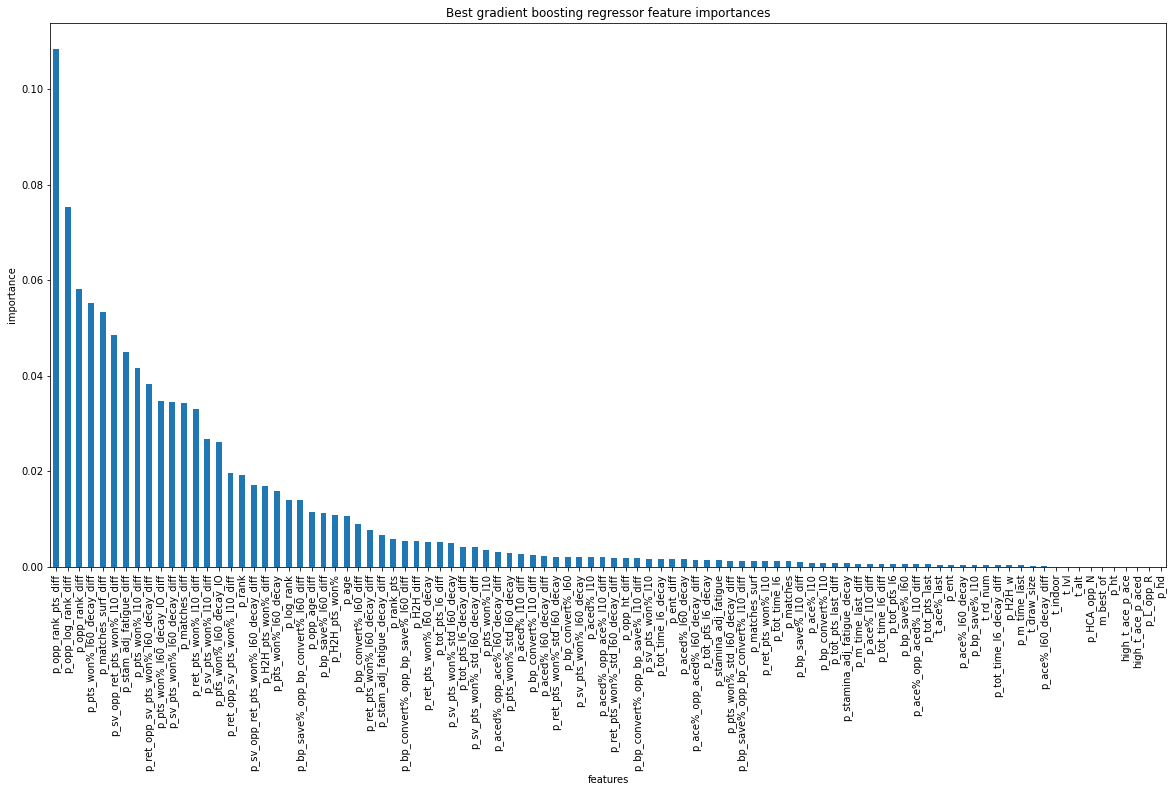

In [31]:
#Plot a barplot of the gradient boosting model's feature importances,
#assigning the `feature_importances_` attribute of 
#`gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

### Data Quality Assessment

In [34]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(GB_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

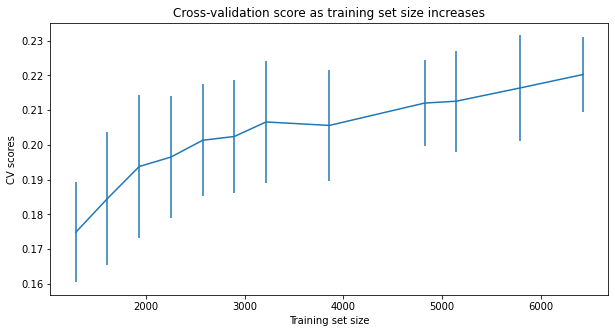

In [35]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');